# Банки — Анализ оттока клиентов

«Метанпромбанк» в срочном порядке ищет аналитиков с уверенным владением «Python». Нашей главной задачей станет анализ оттока клиентов. Анализ покажет, какие клиенты уходят из банка, а так же поможет нам составить сегменты клиентов, которые склонны уходить из банка.

«Метанпромбанк» — деньги не пахнут!

**Описание данных:**

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в
Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:
<br>
**USERID** — идентификатор пользователя,
<br>
**score** — баллы кредитного скоринга,
<br>
**city** — город,
<br>
**gender** — пол,
<br>
**age** — возраст,
<br>
**equity** — количество баллов собственности
<br>
**balance** — баланс на счёте,
<br>
**products** — количество продуктов, которыми пользуется клиент,
<br>
**credit_card** — есть ли кредитная карта,
<br>
**last_activity** — активный клиент,
<br>
**EST_SALARY** — оценочный доход клиента,
<br>
**сhurn** — признак оттока.

**1 Шаг. Загружаем библиотеки и знакомимся с данными.**

In [1]:
!pip install phik

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import scipy.stats as stats
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
import phik

In [3]:
data = pd.read_csv('/datasets/bank_scrooge.csv')

In [4]:
data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


**Вывод:** в датасете представлено 10000 строк и 12 столбцов. Имеются пропуски в колонках "age" и "balance". Названия столбцов "USERID" и "EST_SALARY" следует привести к нижнему регистру и змеиному стилю. Типы данных в колонках "score" и "age" можно привести к целочисленным.

**2 Шаг. Предобработка данных** 

In [6]:
#приведем названия колонок к нижнему регистру и змеиному стилю.
data.columns = [col.lower() for col in data.columns]

In [7]:
data = data.rename(columns={'userid': 'user_id'})

In [8]:
data.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

**2.1 Обработка пропусков**

In [9]:
data.isna().sum()

user_id             0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64

In [10]:
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
user_id,0.000000
score,0.000000
city,0.000000
gender,0.000000
age,0.300000
equity,0.000000
balance,23.000000
products,0.000000
credit_card,0.000000
last_activity,0.000000


In [11]:
# в 'age' всего 0.3% пропусков, удалим их
data = data.dropna(subset=['age'])

В столбце "balance" пропусков 2295, это 23% от общего числа значений. Исследуем причину возникновения пропусков и по возможности обработаем.

In [12]:
# построим корреляцию Пирсона
data.loc[:, data.columns !='user_id'].corr()

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
score,1.000000,-0.011814,0.064809,0.235283,-0.004071,-0.095261,-0.030343,0.164166,0.106404
age,-0.011814,1.000000,0.020628,0.069745,0.017182,-0.123128,-0.008157,-0.039598,-0.049797
equity,0.064809,0.020628,1.000000,0.163793,0.430945,-0.167271,-0.002011,-0.171515,0.270084
balance,0.235283,0.069745,0.163793,1.000000,0.075716,-0.059850,0.024770,0.338800,0.085915
products,-0.004071,0.017182,0.430945,0.075716,1.000000,-0.251120,0.037555,-0.117556,0.300621
credit_card,-0.095261,-0.123128,-0.167271,-0.059850,-0.251120,1.000000,-0.033173,0.036006,-0.130388
last_activity,-0.030343,-0.008157,-0.002011,0.024770,0.037555,-0.033173,1.000000,0.002944,0.169420
est_salary,0.164166,-0.039598,-0.171515,0.338800,-0.117556,0.036006,0.002944,1.000000,0.001705
churn,0.106404,-0.049797,0.270084,0.085915,0.300621,-0.130388,0.169420,0.001705,1.000000


Есть явная положительная зависимость между:
- equity и products - 0.43

Более слабая зависимость между:
- est_salary и balance - 0.34,
- churn и equity - 0.27,
- score и balance - 0.24,
- churn и products - 0.30,
- churn и last_activity - 0.17.

Слабая отрицательная зависимость между:
- equity и credit_card - (-0.17),
- equity и equity - (-0.17),
- products и credit_card - (-0.25)



Создадим новый столбец для признака с пропусками 'balance', который будет иметь два значения: 1-пропуск есть, 0 - пропуска нет.

In [13]:
data['balance_miss'] = data['balance'].isna().astype(int)

In [14]:
data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,balance_miss
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,1
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0


Для определения типа пропусков и их зависимости от остальных переменных применим one-hot кодирование к категориальным значениям с помощью метода get_dummies().

In [15]:
data['city_dummies'] = data['city']
data['gender_dummies'] = data['gender']

In [16]:
data = pd.get_dummies(data, columns = ['city_dummies', 'gender_dummies'])

In [17]:
data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,balance_miss,city_dummies_Ростов,city_dummies_Рыбинск,city_dummies_Ярославль,gender_dummies_Ж,gender_dummies_М
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,0,1,0,1,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,0,1,0,1,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,1,0,1,0,1,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,0,1,1,0
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0,0,1,0,1


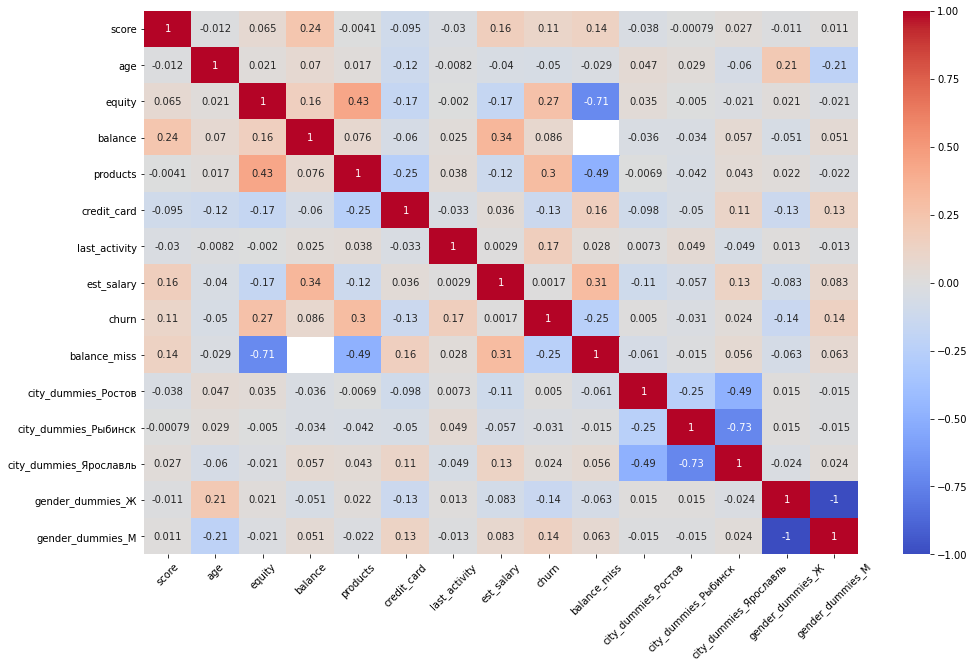

In [18]:
corr = data.loc[:, data.columns !='user_id'].corr()
plt.figure(figsize=(16, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.xticks(rotation=45)
plt.show()

Из таблицы видно, что у balance_miss есть:
- положительная зависимость с est_salary'- 0.31, credit_card - 0.16, score - 0.14.
- отрицательная зависимость с churn - 0.25, products - 0.49, equity - 0.71.
<br>
Выше перечислленные наблюдения говорят что тип пропусков у balance это MNAR (Missing Not At Random / Отсутствует не случайно), поэтому оставим все без изменений.

**2.2 Обработка дуликатов**

In [19]:
#проверка на явные дубликаты
data.duplicated().sum()

0

In [20]:
#неявные дубликаты
double = data.duplicated(subset = ['user_id'], keep=False)
double

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Length: 9974, dtype: bool

In [21]:
data['age'] = data['age'].astype('int')

In [22]:
double = data[data['user_id'].duplicated(keep=False)].sort_values(by='user_id')
pd.set_option('display.max_rows', None)
double

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,balance_miss,city_dummies_Ростов,city_dummies_Рыбинск,city_dummies_Ярославль,gender_dummies_Ж,gender_dummies_М
1893,116540,883.0,Рыбинск,Ж,55,1,362756.49,3,0,1,175920.48,1,0,0,1,0,1,0
7694,116540,887.0,Ярославль,Ж,38,0,NaN,1,0,1,119247.61,0,1,0,0,1,1,0
4866,117943,855.0,Рыбинск,Ж,32,6,1036832.93,4,1,1,107792.71,1,0,0,1,0,1,0
7542,117943,880.0,Ярославль,Ж,40,0,NaN,1,1,0,137718.93,0,1,0,0,1,1,0
5863,120258,908.0,Рыбинск,Ж,38,4,2213581.63,2,0,1,160327.77,1,0,0,1,0,1,0
5896,120258,905.0,Ярославль,М,30,0,NaN,1,1,1,146427.96,0,1,0,0,1,0,1
1411,123461,829.0,Ярославль,Ж,59,0,96222.44,2,0,1,102771.55,1,0,0,0,1,1,0
8638,123461,934.0,Рыбинск,М,34,0,NaN,2,1,0,291619.27,0,1,0,1,0,0,1
9775,124450,758.0,Рыбинск,Ж,36,0,73574.07,2,0,1,79963.59,0,0,0,1,0,1,0
8164,124450,859.0,Ярославль,Ж,38,6,516811.20,1,1,1,95144.63,1,0,0,0,1,1,0


Судя по данным, одинаковый айдишник был присвоен разным клиентам и по технической ошибке. Оставим данные как есть

**Вывод по предобработке данных:**
- названия колонок были приведены к нижнему регистру и змеиному стилю;
- были удалены пропуски в столбце 'age', 23% пропусков типа MNAR в столбце balance остались нетронутыми;
- явных дубликатов найдено не было;
- неявные дубликаты были обнаружены в столбце 'user_id'. Оставили их, так как они появились по технической ошибке.

**3 Шаг. Исследовательский анализ (EDA)**

**3.1 Анализ непрервных признаков**

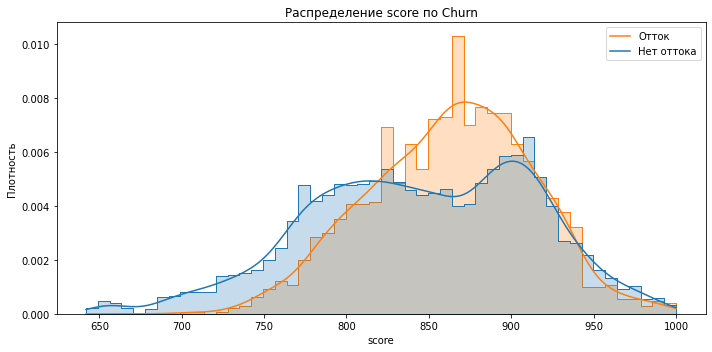

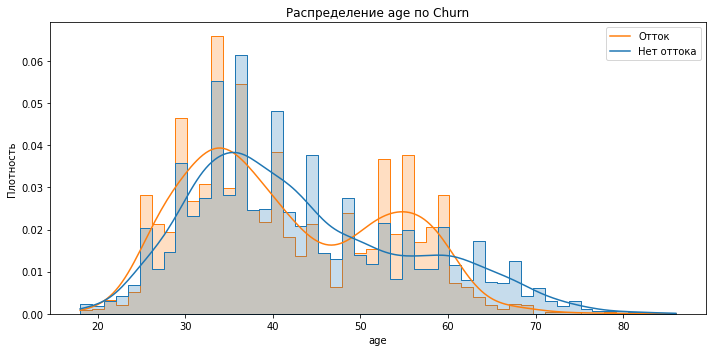

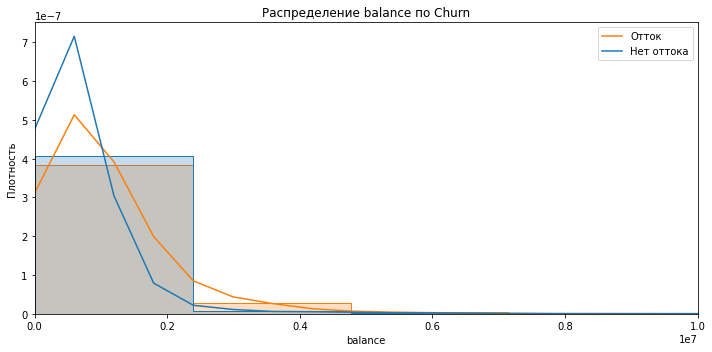

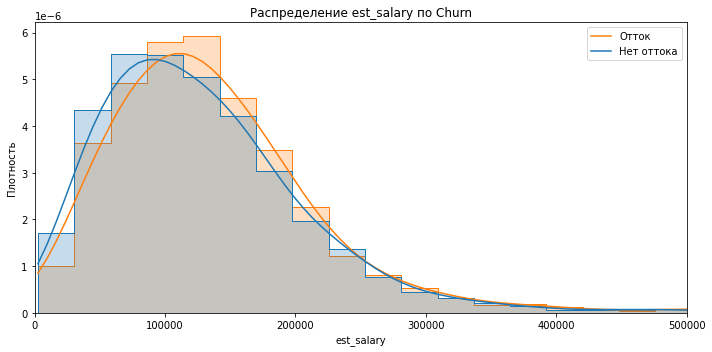

In [23]:
continuous_index = ['score', 'age', 'balance', 'est_salary']

for index in continuous_index:
    plt.figure(figsize=(10, 5))
    sns.histplot(data, x=index, hue="churn", stat="density", common_norm=False, kde=True, bins=50, element="step", fill=True)
    plt.title(f'Распределение {index} по Churn')
    plt.legend(['Отток', 'Нет оттока'])
    plt.ylabel('Плотность')
    
    if index == 'balance':
        plt.xlim(0, 10000000)
    elif index == 'est_salary':
        plt.xlim(0, 500000)
        
    plt.tight_layout()
    plt.show()

- По score видим сильный отток клиентов в диапазоне от 850 до 950;
- Клиенты в возрасте от 25 до 35 и от 50 до 60 лет уходят больше остальных;
- Есть отток клиентов банка с балансом на счете от 1млн;
- Наблюдается отток людей с est_salary от 100 до 230 тысяч рублей.

**3.2 Анализ категориальных признаков**

In [24]:
categorical_index = ['city', 'gender', 'equity', 'products', 'credit_card', 'last_activity']

In [25]:
churn_mean = data['churn'].mean()

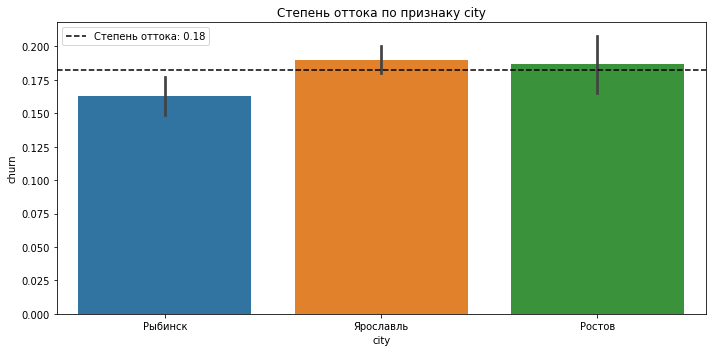

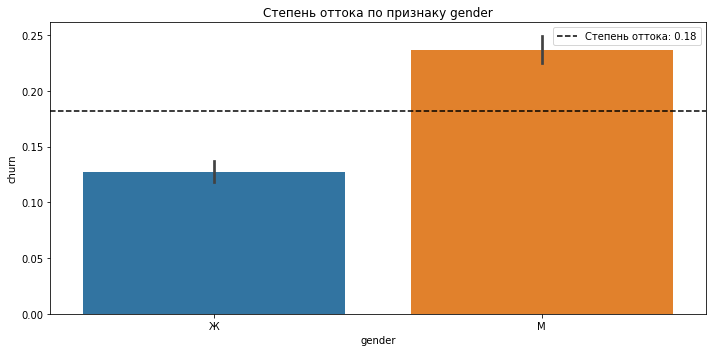

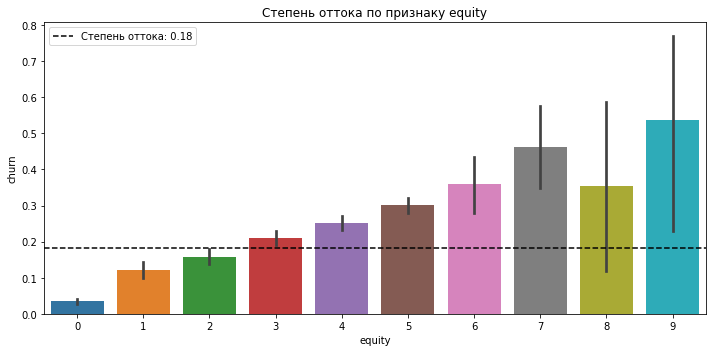

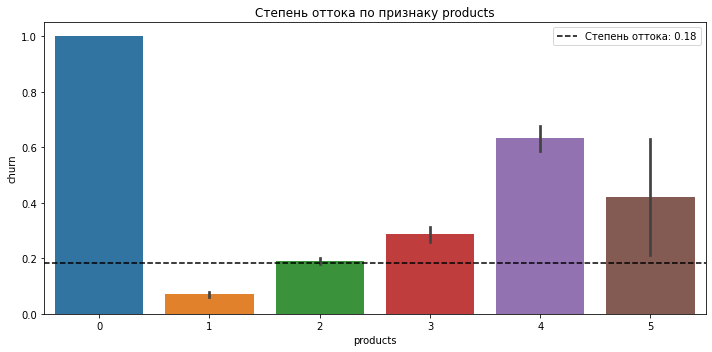

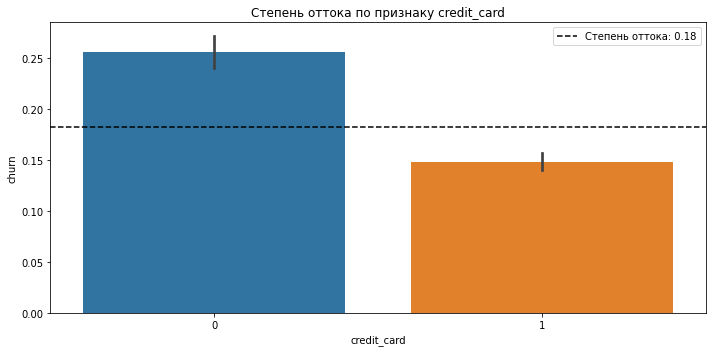

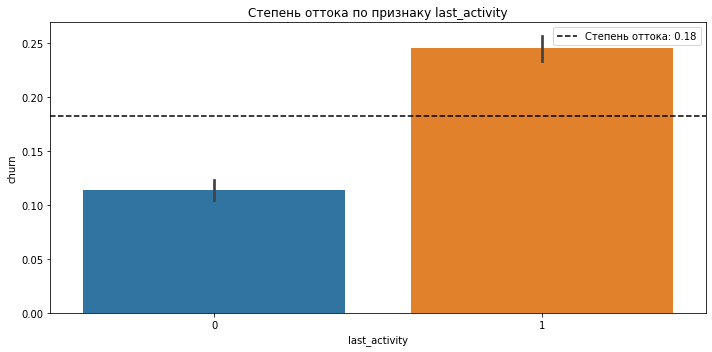

In [26]:
for index in categorical_index:
    plt.figure(figsize=(10, 5))
    
    
    sns.barplot(x=index, y=data['churn'], data=data)
    plt.title(f'Степень оттока по признаку {index}')
    plt.axhline(y=churn_mean, color='black', linestyle='--', label=f'Степень оттока: {churn_mean:.2f}')
    plt.legend()
    
    
    plt.tight_layout()
    plt.show()

- В Ярославле и Ростове уровень оттока выше среднего;
- Мужчины гораздо больше уходят в отток, чем женщины;
- Чем больше баллов собственности, тем выше вероятность ухода;
- Клиенты с двумя и более продуктами перестают сотрудничать с банком. Products = 0 означает, что у человека нет ни одного продукта, следовательно он не может являться клиентом банка, скорее всего это аномальные значения, которые лучше удалим.
- Люди с кредитами реже покидают АКБ;
- Активные клиенты больше других перестают пользоваться услугами банка.

**3.3 Коррелляционный анализ**

In [27]:
#удалим аномальные значения products = 0
data = data[data['products'] != 0]

In [28]:
phik_corr = data.loc[:, ~data.columns.isin(
    ['user_id', 'balance_miss'])].phik_matrix(interval_cols=continuous_index)
phik_churn = phik_corr['churn'].sort_values(ascending=False).reset_index()

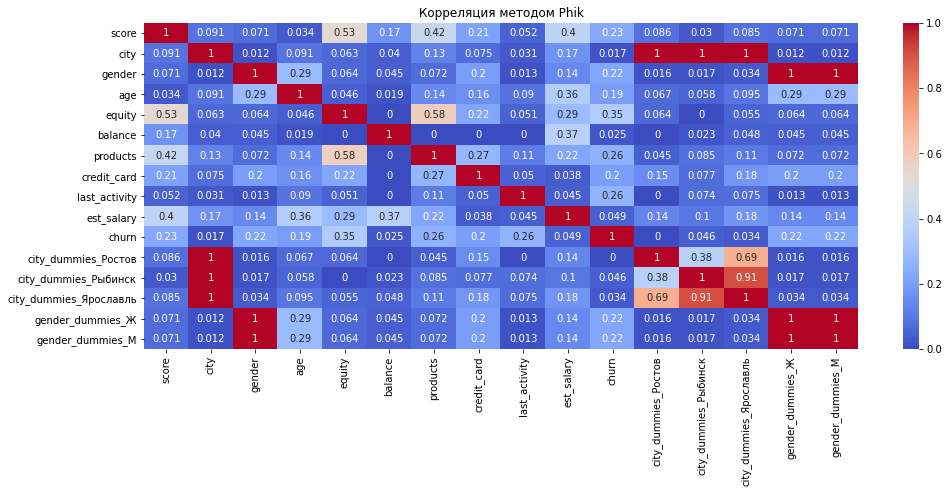

In [29]:
plt.figure(figsize=(16, 6))
sns.heatmap(phik_corr, annot=True, cmap='coolwarm')
plt.title('Корреляция методом Phik')
plt.show()

Явная положительная зависимоть наблюдается между:
- equity и score - (0.53);
- products и score (0.31);
- equity и products (0.44);
- equity и churn (0.35);
- products и credit_card (0.46);
- est_salary  и age (0.36);
- est_salary и balance (0.37);
- est_salary и score (0.39).



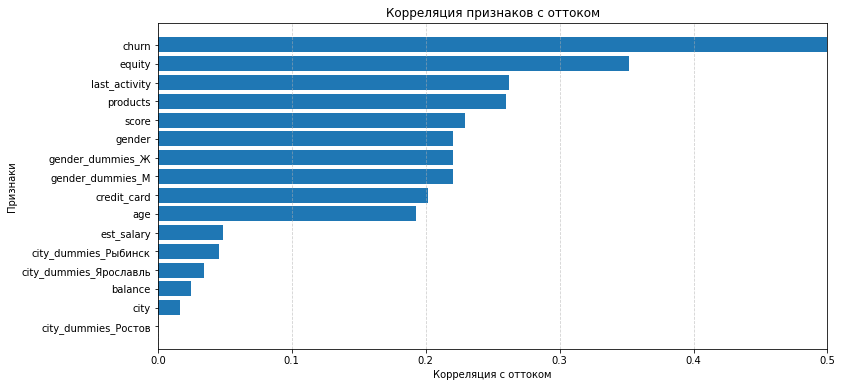

In [30]:
churn_features = phik_churn['index']
correlations = phik_churn['churn']

plt.figure(figsize=(12, 6))
plt.barh(churn_features, correlations)
plt.title('Корреляция признаков с оттоком')
plt.xlim(0, 0.5)
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.6)

plt.ylabel('Признаки')
plt.xlabel('Корреляция с оттоком')
plt.show()

Больше остальных с оттоком корреллируют Products, equity и last_activity. Судя по этому, можем сказать, что клиенты с большим количеством продуктов, активные клиенты и те, у кого высокий капитал, более склонны к покинуть банк.

**Вывод по EDA:**

**Анализ непрервных признаков:**
- По score видим сильный отток клиентов в диапазоне от 850 до 950;
- Клиенты в возрасте от 25 до 35 и от 50 до 60 лет уходят больше остальных;
- Есть отток клиентов банка с балансом на счете от 1млн;
- Наблюдается отток людей с est_salary от 100 до 230 тысяч рублей.

**Анализ категориальных признаков:**
- В Ярославле и Ростове уровень оттока выше среднего;
- Мужчины гораздо больше уходят в отток, чем женщины;
- Чем больше баллов собственности, тем выше вероятность ухода;
- Клиенты с двумя и более продуктами перестают сотрудничать с банком. Products = 0 означает, что у человека нет ни одного продукта, следовательно он не может являться клиентом банка;
- Люди с кредитами реже покидают АКБ;
- Активные клиенты больше других перестают пользоваться услугами банка.

**Корреляционный анализ:**
Больше остальных с оттоком корреллируют Products, equity и last_activity. Судя по этому, можем сказать, что клиенты с большим количеством продуктов, активные клиенты и те, у кого высокий капитал, более склонны покинуть банк.

**Шаг 4. Проверка статистических гипотез**


- **Гипотеза 1:** Клиенты с количеством продуктов больше двух имеют более высокий уровень оттока, чем клиенты с двумя или менее продуктами.
- **Гипотеза 2:** Гипотеза о разнице доходов

**Гипотеза 1:** Клиенты с количеством продуктов больше двух имеют более высокий уровень оттока, чем клиенты с двумя или менее продуктами.

- Нулевая гипотеза (H0): Уровень оттока среди клиентов с количеством продуктов больше двух не отличается от уровня оттока среди клиентов с двумя или менее продуктами.
- Альтернативная гипотеза (H1): Уровень оттока среди клиентов с количеством продуктов больше двух выше, чем среди клиентов с двумя или менее продуктами.

Проверим гипотезу при помощи Z-теста (он подходит для сравнения долей), так как у нас есть бинарные переменные (наличие/отсутствие оттока) и большое количество наблюдений (почти 10000 записей), что делает выбор Z-теста оправданным. Z-тест подходит для сравнения пропорций в двух независимых группах, что соответствует нашей задаче.

Проверка требований для Z-теста:

- Независимость наблюдений: Каждая запись в датафрейме представляет отдельного клиента, и данные по клиентам собраны независимо друг от друга.

- Бинарная зависимая переменная: Переменная churn является бинарной (1 — клиент ушел, 0 — клиент остался), что соответствует требованиям Z-теста.

- Достаточный размер выборки: почти 10000 наблюдений, что достаточно для проведения Z-теста.

In [31]:
products_more_two = data['products'] > 2
products_churn_count = data[products_more_two]['churn'].sum()
products_total_count = products_more_two.sum()

other_products_churn_count = data[~products_more_two]['churn'].sum()
other_products_total_count = (~products_more_two).sum()

stat_products, p_value_products = proportions_ztest([products_churn_count, other_products_churn_count], 
                                                    [products_total_count, other_products_total_count])

print('Z-результат:',stat_products) 
print('p-значение:',p_value_products)

Z-результат: 23.44866387572011
p-значение: 1.3640552852316126e-121


Отвергаем нулевую гипотезу: клиенты с количеством продуктов больше двух имеют значительно более высокий уровень оттока, чем клиенты с двумя или менее продуктами.

**Гипотеза 2:** Гипотеза о разнице доходов

- Нулевая гипотеза (H0): средние доходы оставшихся и отточных клиентов равны.
- Альтернативная гипотеза (H1): средние доходы оставшихся и отточных клиентов различаются.

Для проверки этой гипотезы будем использовать t-тест для независимых выборок. Этот тест проверяет, существует ли статистически значимая разница между средними значениями двух групп.

In [32]:
remaining_customers = data[data['churn'] == 0]['est_salary']
churned_customers = data[data['churn'] == 1]['est_salary']


t_stat, p_value = ttest_ind(remaining_customers, churned_customers, equal_var=False)

print(f't-тест:{t_stat}')
print(f'p_value:{p_value}')

t-тест:-0.20769603970877717
p_value:0.8354803526840116


Не получилось отвергнуть нулевую гипотезу, так как p-значение (0.85) значительно выше стандартного уровня значимости. Статистически значимая разница между средними доходами оставшихся и ушедших клиентов отсутствует.

**Шаг 5. Подведение промежуточных итогов - выводы по результатам EDA, корреляционного анализа и гипотез, выделение признаков, влияющих на оттток.**

- Город: клиенты, проживающие в Ярославле и Ростове, имеют более высокий уровень оттока по сравнению Рыбинском.
- Пол: мужчины чаще уходят в отток, чем женщины.
- Возраст: клиенты в возрасте от 25 до 35 лет и от 50 до 60 лет показывают более высокий уровень оттока. 
- Баллы собственности и баланс на счете: клиенты с высокими баллами собственности и с балансом на счетах более 1 миллиона рублей подвержены риску оттока, вероятно, из-за того, что они более чувствительны к условиям обслуживания и предложениям других банков.
- Активные клиенты: активные клиенты, которые часто пользуются услугами банка, больше всего подвержены оттоку.

**Шаг 6. Сегментация**

**Сегмент 1: Клиенты с высоким доходом и балансом**

- Зарплата: от 100 до 230 тысяч рублей.
- Баланс: более 1 миллиона рублей.

In [33]:
seg_one = data.query("est_salary >= 100000 and est_salary <= 230000 and balance >= 1000000")
print('Количество клиентов в сегменте:', seg_one['churn'].count())
print('Средний уровень оттока:', round(seg_one['churn'].mean() * 100, 2))
print(f"Количество отточных клиентов: {seg_one[seg_one['churn'] == 1]['churn'].count()}")

Количество клиентов в сегменте: 1068
Средний уровень оттока: 43.35
Количество отточных клиентов: 463


**Сегмент 2: Активные клиенты с тремя и более продуктами**

- Количество продуктов: больше двух.
- Есть недавняя активность.
- Баллы собственности : больше трех.

In [34]:
seg_two = data.query("products > 2 and last_activity == 1 and equity > 3")
print('Количество клиентов в сегменте:', seg_two['churn'].count())
print('Средний уровень оттока:', round(seg_two['churn'].mean() * 100, 2))
print(f"Количество отточных клиентов: {seg_two[seg_two['churn'] == 1]['churn'].count()}")

Количество клиентов в сегменте: 532
Средний уровень оттока: 52.44
Количество отточных клиентов: 279


**Сегмент 3: Мужчины без кредитной карты из проблемных регионов**

- Пол: мужской.
- Отсутствие кредитной карты.
- Местоположение: Ярославль или Ростов.

In [35]:
seg_three_city = ['Ярославль', 'Ростов']
seg_three = data.query("credit_card == 0 and gender == 'М' and city in @seg_three_city")
print('Количество клиентов в сегменте:', seg_three['churn'].count())
print('Средний уровень оттока:', round(seg_three['churn'].mean() * 100, 2))
print(f"Количество отточных клиентов: {seg_three[seg_three['churn'] == 1]['churn'].count()}")

Количество клиентов в сегменте: 890
Средний уровень оттока: 37.3
Количество отточных клиентов: 332


**Шаг 7. Приоритизация сегментов**

Приотизируем сегменты по мере убывания отточных клиентов

- Сегмент 1 - 463
- Сегмент 3 - 332
- Сегмент 2 - 279

**Шаг 8. Формирование рекомендаций**

**Сегмент 1: Клиенты с высоким доходом и балансом:**

- Создать специальную программу VIP-обслуживания для клиентов с высоким балансом и доходом. Например туда могут входить помощь в инвестициях и управлении накоплениями.
- Своевременно уведомлять таких клиентов о доступных новых инвестиционных возможностях или финансовых продуктах, которые могут быть интересны, учитывая баланс и доход. 

**Сегмент 2: Активные клиенты с тремя и более продуктами:**

- Оптимизация портфеля продуктов: предоставить персонализированные рекомендации по оптимизации использования текущих продуктов на основе анализа их активности. Это может включать переход на более выгодные тарифные планы или отказу от уже неактуальных продуктов.

- Внедрить элементы игровых заданий, связанных с использованием банковских продуктов. Например, предлагать клиентам выполнять определенные "челленджи" с наградами в виде бонусов или скидок. Это поддержит вовлеченность и укрепит связь клиента с банком.

- Использовать микро-аналитику для прогнозирования потребностей клиента в новых продуктах. Например, если клиент часто использует определенные услуги, предложить дополнительные продукты, которые могут дополнить их текущее использование. Это также может включать "сюрпризы" на основе анализа привычек — например, бонусы за активное использование конкретного продукта.

**Сегмент 3: Мужчины без кредитной карты из проблемных регионов:**

- В рамках кампании по удержанию предложить клиентам, закрывшим кредитные карты, программы "возвращения", включающие специальные бонусы при повторном открытии карты (например, увеличенные лимиты или льготные периоды). Уведомлять мужчин из Ярославля и Ростова о таких акциях через рассылку

- Для клиентов без кредитной карты предложить программы компенсации в виде скидок на определенные продукты или услуги при оформлении карты. Важно также акцентировать внимание на том, как наличие карты может улучшить их финансовое состояние и предложить дополнительный финансовый продукт (например, кешбэк на покупки, страховые программы), который повысит их заинтересованность в кредитной карте.

Ссылка на презентацию : https://disk.yandex.ru/i/A7iL6cuanl8sDw